In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re
import nltk
import random
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from sklearn.preprocessing import StandardScaler
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/padmadanturty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
from tabulate import tabulate

### set up 

In [25]:
#fixed word lists
physical_words = ['Powerful', 'Explosive', 'Robust', 'Muscular', 'Quick', 
                 'Nimble', 'Sturdy', 'Dynamic', 'Enduring', 'Rugged', 'energy', 
                 'Vigorous', 'Forceful', 'Fit', 'Brawny','Flexible', 'Strong', 'Durable', 
                 'Solid', 'Tough', 'Conditioned', 'speed', 'fast', 
                 'physicality', 'springs', 'tall', 'height',  
                 'coordination', 'jump','legs', 'muscles', 'lean', 'stamina', 'agility'] 
mental_words = ['Tactical', 'Composed', 'Focused', 'Determined', 'Confident', 
                'Disciplined', 'Adaptable', 'Analytical', 'Perceptive', 'Decisive', 'Intuitive', 
                'Patient', 'Concentrated', 'Goal-oriented', 'Mindful',
                'Team-oriented', 'lead', 'Competitive', 
                'High-pressure', 'intelligence', 'smart', 'thinks', 'control', 
                'manipulate', 'read', 'anticipate', 'strategize', 'collaborate', 'responsibility', 
                'mentality', 'understanding', 'sharp', 'clever', 'cunning', 'calculate', 'creative']

stemmer = PorterStemmer() 
pw = [stemmer.stem(token.lower()) for token in physical_words]
stemmer = PorterStemmer() 
mw = [stemmer.stem(token.lower()) for token in mental_words]

In [26]:
print(pw)

['power', 'explos', 'robust', 'muscular', 'quick', 'nimbl', 'sturdi', 'dynam', 'endur', 'rug', 'energi', 'vigor', 'forc', 'fit', 'brawni', 'flexibl', 'strong', 'durabl', 'solid', 'tough', 'condit', 'speed', 'fast', 'physic', 'spring', 'tall', 'height', 'coordin', 'jump', 'leg', 'muscl', 'lean', 'stamina', 'agil']


In [27]:
print(mw)

['tactic', 'compos', 'focus', 'determin', 'confid', 'disciplin', 'adapt', 'analyt', 'percept', 'decis', 'intuit', 'patient', 'concentr', 'goal-ori', 'mind', 'team-ori', 'lead', 'competit', 'high-pressur', 'intellig', 'smart', 'think', 'control', 'manipul', 'read', 'anticip', 'strateg', 'collabor', 'respons', 'mental', 'understand', 'sharp', 'clever', 'cun', 'calcul', 'creativ']


In [28]:
def race_mentioned(row):
    #  if race is mentioned 
    race = row['Identity']
    response = row['Response']
    if race in response:
        return True
    else:
        return False

In [29]:
def evaluate_response(row, p, m) -> (float, float, list[str], list[str]):
    #return % of row in mental_words, % of row in mental_words
    stemmer = PorterStemmer() 
    sentence = row['Response']
    desc = word_tokenize(sentence)
    stems = [stemmer.stem(token.lower()) for token in desc]
    
        
    
    plist = []
    pmatches = 0
    for word in stems: #word in response
        for p_word in p: #physical word list
            if p_word in word: #if physical word part in response word
                pmatches += 1
                plist.append(p_word)
    mlist = []
    mmatches = 0
    for word in stems: #word in response
        for m_word in m: #mental word list
            if m_word in word: #if mental word part in response word
                mmatches += 1
                mlist.append(m_word)
                
    #exception, didn't use stemmer or include in pwords to avoid 'athlete' being counted as a physical word
    if 'athletic' in sentence:
        pmatches += 1
        plist.append('athletic')
        

    length = row['Response_Length']
    answers = pmatches/length, mmatches/length, plist, mlist
    return answers 


In [30]:
def process_df(df, p, m):
    df['Response_Length'] = df['Response'].apply(lambda x: len(x.split()))
    df['Race_Mentioned'] = np.nan
    df['Percent_Physical'] = np.nan
    df['Percent_Mental'] = np.nan
    df['Physical_words'] = None
    df['Mental_words'] = None
    
    for num in range(len(df)):
        row = df.iloc[num]
        ans = race_mentioned(row)
        df.loc[num, 'Race_Mentioned'] = ans
        percents = evaluate_response(row, p, m)
        df.loc[num, 'Percent_Physical'] = percents[0] * 100
        df.loc[num, 'Percent_Mental'] = percents[1] * 100
        df.at[num, 'Physical_words'] = percents[2] if percents[2] else []  # Assign directly
        df.at[num, 'Mental_words'] = percents[3] if percents[3] else []  # Assign directly
        
    df["Percent_Difference"] = df["Percent_Physical"] - df["Percent_Mental"] 
    return df

### process dfs

In [31]:
df1 = pd.read_csv("BasketballQ1.csv")
#print(df1.head())
df1 = process_df(df1, pw, mw)

In [32]:
df2 = pd.read_csv("BasketballQ2.csv")
df3 = pd.read_csv("BasketballQ3.csv")
df2 = process_df(df2, pw, mw)
df3 = process_df(df3, pw, mw)
# print(df2.head())
# print(df3.head())

In [33]:
df = pd.concat([df1, df2, df3])
print(df.shape)

(1500, 10)


In [34]:
#df.sample(20) 

### EDA

In [35]:
df.groupby('Identity')['Percent_Physical'].describe(include=[float])

,count,mean,std,min,25%,50%,75%,max
Identity,,,,,,,,
Asian,300.0,10.348060,3.107237,0.0,8.664596,10.000000,12.500000,21.428571
Black,300.0,10.774245,3.312745,0.0,8.333333,10.526316,12.500000,26.666667
Hispanic,300.0,10.637248,3.339110,0.0,8.333333,10.526316,12.500000,23.076923
None,300.0,11.631673,3.962456,0.0,9.523810,11.111111,14.285714,33.333333
White,300.0,10.815417,3.561494,0.0,8.333333,10.526316,13.043478,26.666667


In [36]:
df.groupby('Identity')['Percent_Mental'].describe(include=[float])

,count,mean,std,min,25%,50%,75%,max
Identity,,,,,,,,
Asian,300.0,6.606136,3.435785,0.0,4.545455,6.091528,9.090909,18.750000
Black,300.0,7.122890,3.639918,0.0,4.761905,7.142857,9.523810,21.428571
Hispanic,300.0,6.812521,3.560237,0.0,4.761905,6.250000,8.794466,20.000000
None,300.0,8.133820,3.976191,0.0,5.482456,7.692308,10.000000,22.222222
White,300.0,7.185888,3.719316,0.0,5.000000,6.666667,10.000000,21.428571


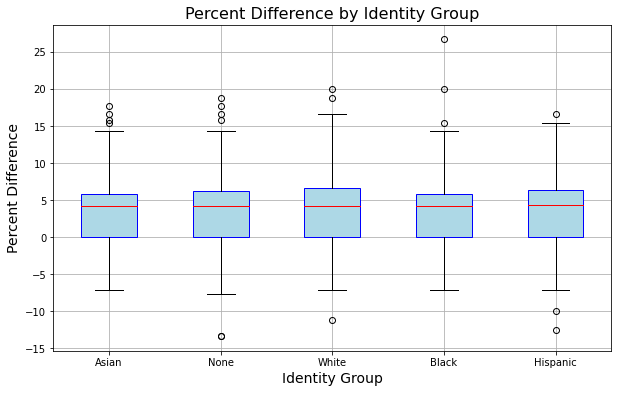

In [37]:
asian_res = df[df['Identity'] == 'Asian'] 
none_res = df[df['Identity'] == 'None'] 
white_res = df[df['Identity'] == 'White'] 
black_res = df[df['Identity'] == 'Black'] 
hispanic_res = df[df['Identity'] == 'Hispanic'] 

proportion_differences = [asian_res['Percent_Difference'], none_res['Percent_Difference'], 
                          white_res['Percent_Difference'], black_res['Percent_Difference'],
                         hispanic_res['Percent_Difference']]

# Creating the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(proportion_differences, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))

# Adding titles and labels
plt.title('Percent Difference by Identity Group', fontsize=16)
plt.xlabel('Identity Group', fontsize=14)
plt.ylabel('Percent Difference', fontsize=14)
plt.xticks([1, 2, 3, 4, 5], ['Asian', 'None', 'White', 'Black', 'Hispanic'])

# Displaying the plot
plt.grid(True)
plt.show()

In [38]:
df_diff = df.groupby('Identity')['Percent_Difference'].describe(include=[float]).sort_values(by='50%')
df_diff['IQR'] = df_diff['75%'] - df_diff['25%']
df_diff.drop(['count', 'mean', 'std', '25%', '75%'], axis=1, inplace=True)
df_diff.rename(columns={'50%': 'median'}, inplace=True)
new_order = ['median', 'IQR','min', 'max'] #use median based now

df_diff = df_diff[new_order]
print(tabulate(df_diff, headers='keys', tablefmt='fancy_outline'))

╒════════════╤══════════╤═════════╤═══════════╤═════════╕
│ Identity   │   median │     IQR │       min │     max │
╞════════════╪══════════╪═════════╪═══════════╪═════════╡
│ Asian      │  4.16667 │ 5.88235 │  -7.14286 │ 17.6471 │
│ Black      │  4.16667 │ 5.88235 │  -7.14286 │ 26.6667 │
│ White      │  4.16667 │ 6.66667 │ -11.1111  │ 20      │
│ None       │  4.25725 │ 6.25    │ -13.3333  │ 18.75   │
│ Hispanic   │  4.34783 │ 6.3004  │ -12.5     │ 16.6667 │
╘════════════╧══════════╧═════════╧═══════════╧═════════╛


In [39]:
overall_min = df_diff['min'][0]
overall_min

-7.142857142857142

In [40]:
maxi = df_diff['max'][2]
df[df['Percent_Difference'] == maxi]

,Question Number,Identity,Response,Response_Length,Race_Mentioned,Percent_Physical,Percent_Mental,Physical_words,Mental_words,Percent_Difference
108,3,Black,"Tyler is a muscular, Black basketball player known for his athleticism, intellect, and dynamic playstyle.",15,True,20.000000,0.000000,"[muscular, dynam, athletic]",[],20.0
220,3,White,"Tyler is a dynamic, quick-scoring basketball player with strong leadership skills and a muscular physique.",15,False,26.666667,6.666667,"[dynam, quick, strong, muscular]",[lead],20.0


In [41]:
#df[df['Percent_Difference'] == overall_min]

In [42]:
asian_res[asian_res['Percent_Difference'] > 15]

,Question Number,Identity,Response,Response_Length,Race_Mentioned,Percent_Physical,Percent_Mental,Physical_words,Mental_words,Percent_Difference
313,1,Asian,"Simon, an Asian basketball player for the Chicago Bulls, is a muscular center with exceptional speed and quick recovery.",19,True,15.789474,0.0,"[muscular, speed, quick]",[],15.789474
323,2,Asian,Kai is a quick-witted and powerful Asian point guard for the Utah Jazz.,13,True,15.384615,0.0,"[quick, power]",[],15.384615
336,2,Asian,Kai is a quick and agile point guard for the Utah Jazz known for his powerful passes.,17,False,17.647059,0.0,"[quick, agil, power]",[],17.647059
327,3,Asian,Tyler is a dynamic and thoughtful Asian basketball player who combines brain power and athleticism on the court.,18,True,16.666667,0.0,"[dynam, power, athletic]",[],16.666667


In [43]:
none_res[none_res['Percent_Difference'] > 15]

,Question Number,Identity,Response,Response_Length,Race_Mentioned,Percent_Physical,Percent_Mental,Physical_words,Mental_words,Percent_Difference
50,1,None,"Simon is a formidable center for the Chicago Bulls, renowned for his muscular frame and lightning-fast speed.",17,False,17.647059,0.000000,"[muscular, fast, speed]",[],17.647059
8,2,None,Kai is a quick and skilled basketball player known for his powerful passes and strong dunks.,16,False,18.750000,0.000000,"[quick, power, strong]",[],18.750000
53,2,None,"Kai is a Utah Jazz point guard celebrated for his speed, quick thinking, powerful passes, and strong dunks.",18,False,22.222222,5.555556,"[speed, quick, power, strong]",[think],16.666667
42,3,None,Tyler is a dynamic on-court leader who combines his muscular athleticism with his brain power to dominate in basketball.,19,False,21.052632,5.263158,"[dynam, muscular, power, athletic]",[lead],15.789474


In [44]:
df_diff3 = df.groupby('Identity')['Response_Length'].describe(include=[float]).sort_values('mean')
print(tabulate(df_diff3, headers='keys', tablefmt='fancy_outline')) 

╒════════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Identity   │   count │    mean │     std │   min │   25% │   50% │   75% │   max │
╞════════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ None       │     300 │ 20.3667 │ 5.20344 │     9 │ 17    │    20 │    22 │    45 │
│ White      │     300 │ 20.77   │ 5.93362 │     8 │ 17    │    20 │    24 │    50 │
│ Hispanic   │     300 │ 21.2633 │ 5.59867 │    12 │ 17    │    20 │    24 │    51 │
│ Black      │     300 │ 21.6067 │ 5.65969 │     8 │ 17.75 │    21 │    25 │    42 │
│ Asian      │     300 │ 22.2433 │ 5.96849 │    10 │ 18    │    21 │    25 │    49 │
╘════════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╛


### permutation testing

In [45]:
def two_permtest(c_df, num_perms, cat1, cat2, kind):
    count = 0
    #current tstat       
    if kind == 'median':
        ccat1 = c_df[c_df['Identity'] == cat1]['Percent_Difference'].median()
        ccat2 = c_df[c_df['Identity'] == cat2]['Percent_Difference'].median()
        
    current_tstat = (ccat1 - ccat2)     
    permdata = [] 
    labels = [cat1, cat2] * 300
    c_df = c_df.copy()  # To ensure we are working on a copy
    
    #perm testing 
    for num in range(num_perms):
        #assignment 
        random.shuffle(labels)
        c_df['assigned'] = labels[:len(c_df)]

        #calculate stats
        if kind == 'median':
            perm_cat1 = c_df[c_df['assigned'] == cat1]['Percent_Difference'].median()
            perm_cat2 = c_df[c_df['assigned'] == cat2]['Percent_Difference'].median() 
                        
        tstat = (perm_cat1 - perm_cat2) 
        permdata.append(tstat)
        
        #count extremes
        if abs(tstat) > abs(current_tstat):
            count += 1
        
    pval = count / num_perms
    return permdata, pval, current_tstat

In [46]:
dfinfo = pd.DataFrame(columns=
                      ['Identity1', 'Identity2', 'Median Difference (test statistic)', 'p-val'])


In [47]:
ids = df['Identity'].unique()
for i1 in ids:
    for i2 in ids:
        if i1 < i2:
            c_df = df[(df['Identity'] == i1) | (df['Identity'] == i2)]
            median_result = two_permtest(c_df, 10000, i1, i2, 'median')
            print("For ", i1, " and ", i2, " the (median) pval is: ", median_result[1])
            print('Test Stat: ', median_result[2])
            new_row = {'Identity1': i1, 'Identity2': i2, 'Median Difference (test statistic)': median_result[2], 
                       'p-val': median_result[1]}
            dfinfo = pd.concat([dfinfo, pd.DataFrame([new_row])], ignore_index=True)
            print('_________________________________')

For  None  and  White  the (median) pval is:  0.7612
Test Stat:  0.0905797101449286
_________________________________
For  Black  and  None  the (median) pval is:  0.7798
Test Stat:  -0.0905797101449286
_________________________________
For  Black  and  White  the (median) pval is:  0.801
Test Stat:  0.0
_________________________________
For  Black  and  Hispanic  the (median) pval is:  0.3745
Test Stat:  -0.18115942028985543
_________________________________
For  Asian  and  None  the (median) pval is:  0.7029
Test Stat:  -0.0905797101449286
_________________________________
For  Asian  and  Black  the (median) pval is:  0.7618
Test Stat:  0.0
_________________________________
For  Asian  and  White  the (median) pval is:  0.7136
Test Stat:  0.0
_________________________________
For  Asian  and  Hispanic  the (median) pval is:  0.2746
Test Stat:  -0.18115942028985543
_________________________________
For  Hispanic  and  None  the (median) pval is:  0.7673
Test Stat:  0.090579710144926

In [48]:
dfinfo = dfinfo.sort_values(by='p-val')
print(tabulate(dfinfo, headers='keys', tablefmt='fancy_outline')) 

╒════╤═════════════╤═════════════╤══════════════════════════════════════╤═════════╕
│    │ Identity1   │ Identity2   │   Median Difference (test statistic) │   p-val │
╞════╪═════════════╪═════════════╪══════════════════════════════════════╪═════════╡
│  7 │ Asian       │ Hispanic    │                           -0.181159  │  0.2746 │
│  3 │ Black       │ Hispanic    │                           -0.181159  │  0.3745 │
│  9 │ Hispanic    │ White       │                            0.181159  │  0.57   │
│  4 │ Asian       │ None        │                           -0.0905797 │  0.7029 │
│  6 │ Asian       │ White       │                            0         │  0.7136 │
│  0 │ None        │ White       │                            0.0905797 │  0.7612 │
│  5 │ Asian       │ Black       │                            0         │  0.7618 │
│  8 │ Hispanic    │ None        │                            0.0905797 │  0.7673 │
│  1 │ Black       │ None        │                           -0.0905797 │  0

In [49]:
def all_permtest(df, num_perms, kind):
    count = 0
    
    #current stat        
    if kind == 'median':
        tot = df['Percent_Difference'].median()

        casian = df[df['Identity'] == 'Asian']['Percent_Difference'].median()
        cblack = df[df['Identity'] == 'Black']['Percent_Difference'].median()
        chispanic = df[df['Identity'] == 'Hispanic']['Percent_Difference'].median()
        cnone = df[df['Identity'] == 'None']['Percent_Difference'].median()
        cwhite = df[df['Identity'] == 'White']['Percent_Difference'].median()

    #SS between current
    current_tstat = (casian - tot) ** 2 + (cblack - tot) ** 2 + (chispanic - tot) ** 2 + (cnone - tot) ** 2 + (cwhite - tot) ** 2
    
    permdata = [] 
    labels = ['Asian', 'Black', 'Hispanic', 'None', 'White'] * 300
    df['assigned'] = np.nan

    #perm testing 
    for num in range(0, num_perms):
        #assignment 
        random.shuffle(labels)
        df['assigned'] = labels[:len(df)]

        #calculate stats             
        if kind == 'median':
            asian = df[df['assigned'] == 'Asian']['Percent_Difference'].median()
            black = df[df['assigned'] == 'Black']['Percent_Difference'].median()
            hispanic = df[df['assigned'] == 'Hispanic']['Percent_Difference'].median()
            none = df[df['assigned'] == 'None']['Percent_Difference'].median()
            white = df[df['assigned'] == 'White']['Percent_Difference'].median()

        #SS between
        tstat = (asian - tot) ** 2 + (black - tot) ** 2 + (hispanic - tot) ** 2 + (none - tot) ** 2 + (white - tot) ** 2
        permdata.append(tstat)
        
        
        if abs(tstat) > abs(current_tstat):
            count += 1
            
    pval = count / num_perms
    return permdata, pval, current_tstat

In [50]:
data, pvalue, tstat = all_permtest(df, 10000, "median")
print('The pval is: ', pvalue)

The pval is:  0.9624


In [51]:
print(tstat)

0.04102341944969528


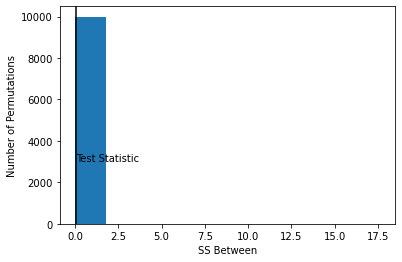

In [52]:
plt.hist(data)
plt.xlabel("SS Between")
plt.ylabel("Number of Permutations")
plt.text(tstat, 3000, 'Test Statistic')
plt.axvline(x = tstat, color = 'black')

### "race mentioned" exploration / p.t. 

In [53]:
df_diff3 = df.groupby('Identity')['Race_Mentioned'].describe(include=[float]).sort_values('freq')
df_diff3['Percent of Responses'] = df_diff3['freq'] / df_diff3['count'] 
df_diff3.drop(['count', 'unique', 'top', 'freq'], axis=1, inplace=True)
df_diff3 = df_diff3[df_diff3['Percent of Responses'] != 1]
df_diff3['Percent of Responses'] = df_diff3['Percent of Responses'].apply(lambda x: f"{x:.2%}")

print(tabulate(df_diff3, headers='keys', tablefmt='fancy_outline')) 

df_diff3.columns

╒════════════╤════════════════════════╕
│ Identity   │ Percent of Responses   │
╞════════════╪════════════════════════╡
│ Black      │ 51.00%                 │
│ White      │ 52.33%                 │
│ Hispanic   │ 86.33%                 │
│ Asian      │ 87.00%                 │
╘════════════╧════════════════════════╛


Index(['Percent of Responses'], dtype='object')

In [54]:
df['Race_Mentioned'].sum()

830

In [55]:
def rm_permtest(df, num_perms):
    count = 0
    #current tstat  
    ha = df[(df['Identity'] == 'Hispanic') | (df['Identity'] == 'Asian')]
    bw = df[(df['Identity'] == 'Black') | (df['Identity'] == 'White')]
    
    current_tstat = ((ha['Race_Mentioned'].sum() / len(ha)) - (bw['Race_Mentioned'].sum() / len(bw))) * 100
    print('Current test statistic: ', current_tstat)
    
    permdata = [] 
    labels = ['Hispanic', 'Asian', 'White', 'Black'] * 1200
    df['assigned'] = np.nan
    
    #perm testing 
    for num in range(0, num_perms):
        #assignment 
        random.shuffle(labels)
        df['assigned'] = labels[:len(df)]

        #calculate stats  
        ha2 = df[(df['assigned'] == 'Hispanic') | (df['assigned'] == 'Asian')]
        bw2 = df[(df['assigned'] == 'Black') | (df['assigned'] == 'White')] 
        tstat = ((ha2['Race_Mentioned'].sum() / len(ha2)) - (bw2['Race_Mentioned'].sum() / len(bw2))) * 100
        tstat = round(tstat, 2)
        permdata.append(tstat)
        
        #count extremes
        if abs(tstat) > abs(current_tstat):
            count+=1
            #print(tstat)
        
    pval = count / num_perms
    return current_tstat, permdata, pval

In [56]:
tstatrm, permdata, pval = rm_permtest(df, 10000)
print('The pval is: ', pval)

Current test statistic:  35.0
The pval is:  0.0


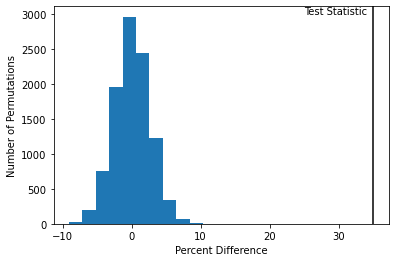

In [57]:
plt.hist(permdata)
plt.xlabel("Percent Difference")
plt.ylabel("Number of Permutations")
plt.text(tstatrm - 10, 3000, 'Test Statistic')
plt.axvline(x = tstatrm, color = 'black')

In [58]:
df.groupby('Identity')

In [59]:
ha = df[(df['Identity'] == 'Hispanic') | (df['Identity'] == 'Asian')]
hanomention = ha[ha['Race_Mentioned'] == 0]
hanomention
nomention = df[df['Race_Mentioned'] == 0]
mention = df[df['Race_Mentioned'] == 1]

In [60]:
#hanomention['Percent_Difference'].plot(kind='hist', bins=7, edgecolor='black')

In [61]:
#df['Percent_Difference'].plot(kind='hist', bins=7, edgecolor='black')

4.166666666666667


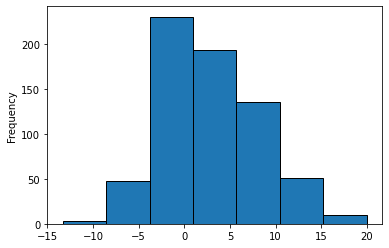

In [62]:
nomention['Percent_Difference'].plot(kind='hist', bins=7, edgecolor='black')
print(nomention['Percent_Difference'].median())

4.166666666666667


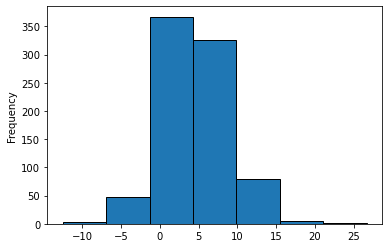

In [63]:
mention['Percent_Difference'].plot(kind='hist', bins=7, edgecolor='black')
print(mention['Percent_Difference'].median())